In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn pycombat

In [ ]:
# Assuming you have a way to generate the correct batch list for all 31575 samples
# For example, if the first 15000 are batch1 and the rest are batch2:
# batch_list = ["batch1"]*15000 + ["batch2"]*(df.shape[1] - 15000)
# batch = pd.Series(batch_list, index=sample_names)

# Replace the following line with the correct logic for your data:
batch = ["batch1"]*50 + ["batch2"]*50  # This line is incorrect as it assumes only 100 samples

# You must replace the line above with code that correctly generates a list
# of batch labels for all df.shape[1] samples (31575 in this case)
# and then convert it to a pandas Series with the correct index.

# Example if you want to just create placeholder batches for demonstration:
num_samples = df.shape[1]
batch = ["batch1"] * (num_samples // 2) + ["batch2"] * (num_samples - num_samples // 2)
batch = pd.Series(batch, index=sample_names)

Original number of genes (rows): 1224
Number of genes after imputation: 1224
Shape of data before ComBat (samples x genes): (31575, 1224)


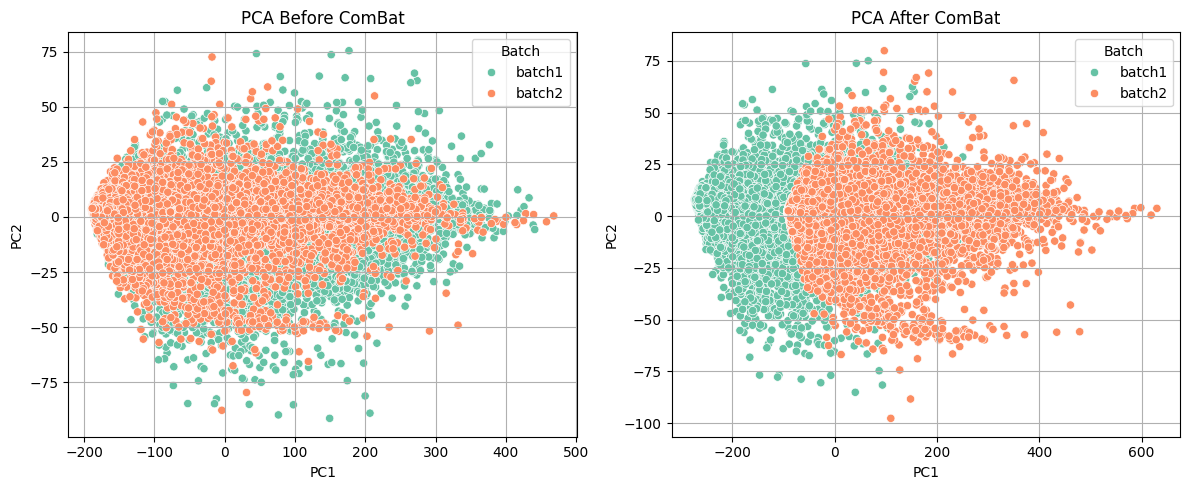

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pycombat import Combat

# === Step 1: Load the dataset ===
# Example assumes rows are genes, columns are samples
df = pd.read_csv("BRCA_gene_expression.csv", index_col=0)

# Optional: transpose if genes are in columns and samples are rows
# df = df.T

# === Step 2: Define batch information ===
# You must have a batch vector (same order as columns of df)
# Example: if you know batches from sample names or metadata
sample_names = df.columns

# === FIX: Ensure df is entirely numeric and handle NaNs ===
# Convert all columns to numeric, coercing errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# --- CHANGE: Handle NaN values by imputation instead of dropping rows ---
original_rows = df_numeric.shape[0]
print(f"Original number of genes (rows): {original_rows}")

# Impute missing values (NaNs) with the mean of each row (gene)
# This assumes that missing values for a gene can be represented by its average expression
# Be aware that other imputation methods might be more appropriate depending on your data and goals
df_imputed = df_numeric.T.fillna(df_numeric.T.mean()).T # Impute column-wise (genes are columns after transpose)
rows_after_imputation = df_imputed.shape[0]
print(f"Number of genes after imputation: {rows_after_imputation}")

# Use the imputed DataFrame for subsequent steps
df = df_imputed

# Add a check to ensure the DataFrame is purely numeric after imputation
# and convert to float64 explicitly if not already.
# This helps ensure consistency for numerical operations.
if not df.apply(pd.api.types.is_numeric_dtype).all():
    print("Warning: Some columns in df are not numeric after imputation.")
    # Attempt to force all columns to float64, coercing errors
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).astype(np.float64)

# --- END CHANGE ---

# Re-create batch list and Series based on the cleaned df's columns (samples)
# Since we handled NaNs by imputation (and not dropping columns), the number of samples remains the same.
num_samples = df.shape[1]
batch_list = ["batch1"] * (num_samples // 2) + ["batch2"] * (num_samples - num_samples // 2)
batch = pd.Series(batch_list, index=df.columns) # Use df.columns here just in case

# Convert string batch labels to numerical labels (re-doing this step to be safe)
batch_map = {label: i for i, label in enumerate(batch.unique())}
batch_numerical = batch.map(batch_map)

# === Step 3: Apply ComBat ===
combat = Combat()
# Pass the numerical batch Series to fit_transform
# Ensure df is transposed so samples are in rows (ComBat expects samples in rows)

# --- ADDED: Check the shape of the transposed DataFrame before passing to ComBat ---
print(f"Shape of data before ComBat (samples x genes): {df.T.shape}")
# --- END ADDED ---

# --- CHANGE: Convert df.T and batch_numerical to NumPy arrays before passing to combat ---
# This avoids potential pandas indexing issues within pycombat
df_corrected_np = combat.fit_transform(df.T.values, batch_numerical.values)
# Convert the corrected NumPy array back to a pandas DataFrame with original index and columns
df_corrected = pd.DataFrame(df_corrected_np.T, index=df.index, columns=df.columns)
# --- END CHANGE ---


# === Step 4: PCA before and after correction ===
def plot_pca(data, title, batch_labels):
    # Ensure the data for PCA is numeric
    # Removed coerce errors here as df is expected to be clean now
    data_numeric = data.astype(np.float64)
    # Drop columns/rows with NaNs that might have been introduced (less likely after initial cleaning, but good practice)
    # Drop columns then rows for PCA (PCA expects samples in rows)
    data_cleaned_for_pca = data_numeric.dropna(axis=1).dropna(axis=0)

    if data_cleaned_for_pca.shape[1] < 2:
         print(f"Warning: Not enough features ({data_cleaned_for_pca.shape[1]}) for PCA on '{title}'. Skipping plot.")
         return

    # Align batch labels to the samples remaining after cleaning for PCA
    samples_kept_for_pca = data_cleaned_for_pca.columns
    # Ensure batch_labels is indexed by sample names
    # Use .loc for potentially non-unique indices if necessary, though .columns should be unique
    batch_labels_aligned = batch_labels.loc[samples_kept_for_pca]


    pca = PCA(n_components=2)
    # PCA expects samples in rows, so transpose the data for PCA
    pcs = pca.fit_transform(data_cleaned_for_pca.T)
    pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
    # Ensure batch_labels_aligned values are used, and align the index with pc_df
    pc_df['Batch'] = batch_labels_aligned.values # Use the original string labels for plotting clarity
    pc_df.index = data_cleaned_for_pca.columns # Set the index to sample names for clarity if needed later

    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Batch', palette='Set2')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.tight_layout()

plt.figure(figsize=(12, 5))

# Before ComBat
plt.subplot(1, 2, 1)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df, "PCA Before ComBat", batch) # Use original string batch for plotting

# After ComBat
plt.subplot(1, 2, 2)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df_corrected, "PCA After ComBat", batch) # Use original string batch for plotting

plt.show()

Original number of genes (rows): 562
Number of genes after imputation: 562
Shape of data before ComBat (samples x genes): (31506, 562)


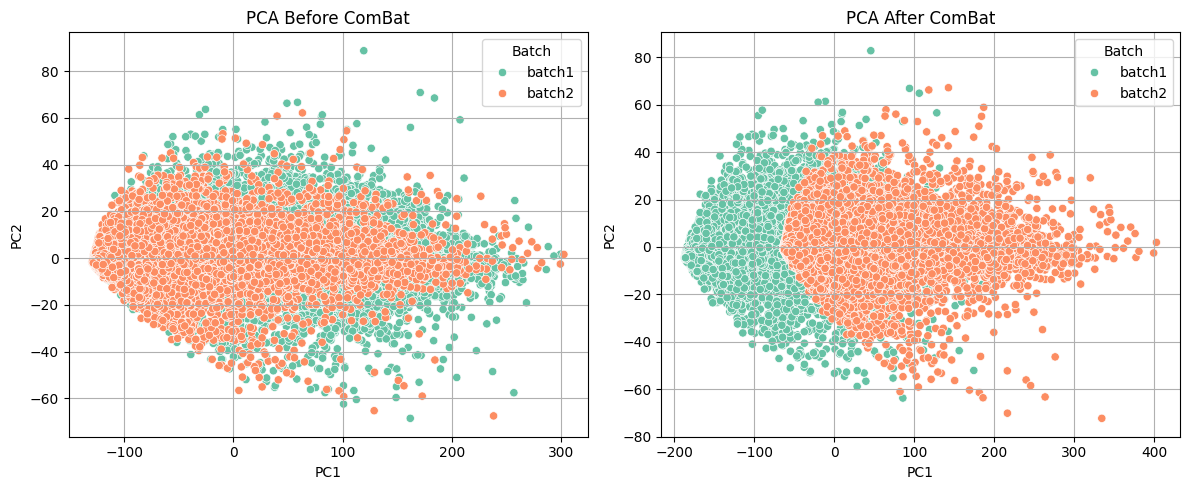

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pycombat import Combat

# === Step 1: Load the dataset ===
# Example assumes rows are genes, columns are samples
df = pd.read_csv("Lung_gene_expression.csv", index_col=0)

# Optional: transpose if genes are in columns and samples are rows
# df = df.T

# === Step 2: Define batch information ===
# You must have a batch vector (same order as columns of df)
# Example: if you know batches from sample names or metadata
sample_names = df.columns

# === FIX: Ensure df is entirely numeric and handle NaNs ===
# Convert all columns to numeric, coercing errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# --- CHANGE: Handle NaN values by imputation instead of dropping rows ---
original_rows = df_numeric.shape[0]
print(f"Original number of genes (rows): {original_rows}")

# Impute missing values (NaNs) with the mean of each row (gene)
# This assumes that missing values for a gene can be represented by its average expression
# Be aware that other imputation methods might be more appropriate depending on your data and goals
df_imputed = df_numeric.T.fillna(df_numeric.T.mean()).T # Impute column-wise (genes are columns after transpose)
rows_after_imputation = df_imputed.shape[0]
print(f"Number of genes after imputation: {rows_after_imputation}")

# Use the imputed DataFrame for subsequent steps
df = df_imputed

# Add a check to ensure the DataFrame is purely numeric after imputation
# and convert to float64 explicitly if not already.
# This helps ensure consistency for numerical operations.
if not df.apply(pd.api.types.is_numeric_dtype).all():
    print("Warning: Some columns in df are not numeric after imputation.")
    # Attempt to force all columns to float64, coercing errors
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).astype(np.float64)

# --- END CHANGE ---

# Re-create batch list and Series based on the cleaned df's columns (samples)
# Since we handled NaNs by imputation (and not dropping columns), the number of samples remains the same.
num_samples = df.shape[1]
batch_list = ["batch1"] * (num_samples // 2) + ["batch2"] * (num_samples - num_samples // 2)
batch = pd.Series(batch_list, index=df.columns) # Use df.columns here just in case

# Convert string batch labels to numerical labels (re-doing this step to be safe)
batch_map = {label: i for i, label in enumerate(batch.unique())}
batch_numerical = batch.map(batch_map)

# === Step 3: Apply ComBat ===
combat = Combat()
# Pass the numerical batch Series to fit_transform
# Ensure df is transposed so samples are in rows (ComBat expects samples in rows)

# --- ADDED: Check the shape of the transposed DataFrame before passing to ComBat ---
print(f"Shape of data before ComBat (samples x genes): {df.T.shape}")
# --- END ADDED ---

# --- CHANGE: Convert df.T and batch_numerical to NumPy arrays before passing to combat ---
# This avoids potential pandas indexing issues within pycombat
df_corrected_np = combat.fit_transform(df.T.values, batch_numerical.values)
# Convert the corrected NumPy array back to a pandas DataFrame with original index and columns
df_corrected = pd.DataFrame(df_corrected_np.T, index=df.index, columns=df.columns)
# --- END CHANGE ---


# === Step 4: PCA before and after correction ===
def plot_pca(data, title, batch_labels):
    # Ensure the data for PCA is numeric
    # Removed coerce errors here as df is expected to be clean now
    data_numeric = data.astype(np.float64)
    # Drop columns/rows with NaNs that might have been introduced (less likely after initial cleaning, but good practice)
    # Drop columns then rows for PCA (PCA expects samples in rows)
    data_cleaned_for_pca = data_numeric.dropna(axis=1).dropna(axis=0)

    if data_cleaned_for_pca.shape[1] < 2:
         print(f"Warning: Not enough features ({data_cleaned_for_pca.shape[1]}) for PCA on '{title}'. Skipping plot.")
         return

    # Align batch labels to the samples remaining after cleaning for PCA
    samples_kept_for_pca = data_cleaned_for_pca.columns
    # Ensure batch_labels is indexed by sample names
    # Use .loc for potentially non-unique indices if necessary, though .columns should be unique
    batch_labels_aligned = batch_labels.loc[samples_kept_for_pca]


    pca = PCA(n_components=2)
    # PCA expects samples in rows, so transpose the data for PCA
    pcs = pca.fit_transform(data_cleaned_for_pca.T)
    pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
    # Ensure batch_labels_aligned values are used, and align the index with pc_df
    pc_df['Batch'] = batch_labels_aligned.values # Use the original string labels for plotting clarity
    pc_df.index = data_cleaned_for_pca.columns # Set the index to sample names for clarity if needed later

    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Batch', palette='Set2')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.tight_layout()

plt.figure(figsize=(12, 5))

# Before ComBat
plt.subplot(1, 2, 1)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df, "PCA Before ComBat", batch) # Use original string batch for plotting

# After ComBat
plt.subplot(1, 2, 2)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df_corrected, "PCA After ComBat", batch) # Use original string batch for plotting

plt.show()

Original number of genes (rows): 461
Number of genes after imputation: 461
Shape of data before ComBat (samples x genes): (58735, 461)


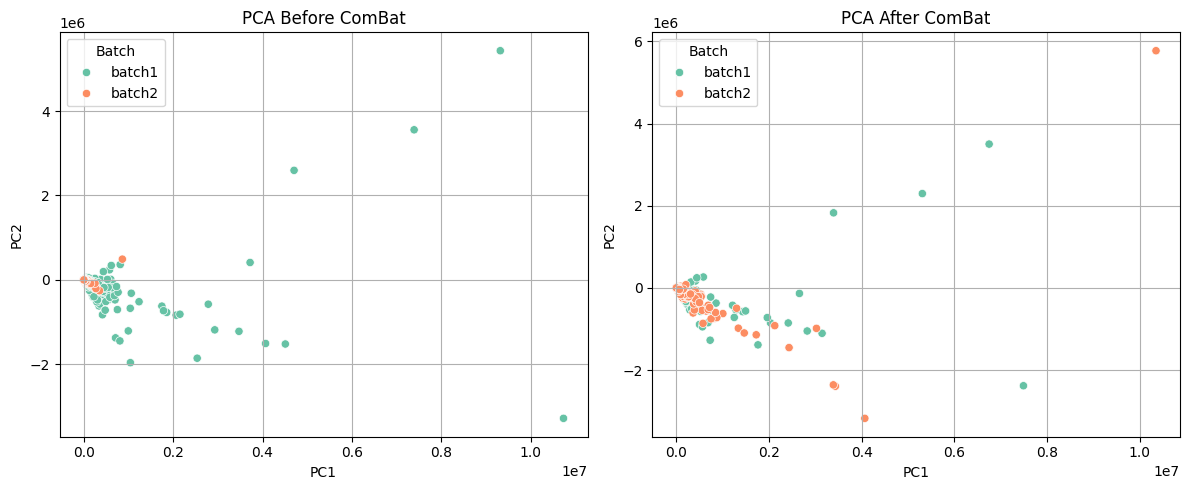

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pycombat import Combat

# === Step 1: Load the dataset ===
# Example assumes rows are genes, columns are samples
df = pd.read_csv("trial_dataframe.csv", index_col=0)

# Optional: transpose if genes are in columns and samples are rows
# df = df.T

# === Step 2: Define batch information ===
# You must have a batch vector (same order as columns of df)
# Example: if you know batches from sample names or metadata
sample_names = df.columns

# === FIX: Ensure df is entirely numeric and handle NaNs ===
# Convert all columns to numeric, coercing errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# --- CHANGE: Handle NaN values by imputation instead of dropping rows ---
original_rows = df_numeric.shape[0]
print(f"Original number of genes (rows): {original_rows}")

# Impute missing values (NaNs) with the mean of each row (gene)
# This assumes that missing values for a gene can be represented by its average expression
# Be aware that other imputation methods might be more appropriate depending on your data and goals
df_imputed = df_numeric.T.fillna(df_numeric.T.mean()).T # Impute column-wise (genes are columns after transpose)
rows_after_imputation = df_imputed.shape[0]
print(f"Number of genes after imputation: {rows_after_imputation}")

# Use the imputed DataFrame for subsequent steps
df = df_imputed

# Add a check to ensure the DataFrame is purely numeric after imputation
# and convert to float64 explicitly if not already.
# This helps ensure consistency for numerical operations.
if not df.apply(pd.api.types.is_numeric_dtype).all():
    print("Warning: Some columns in df are not numeric after imputation.")
    # Attempt to force all columns to float64, coercing errors
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).astype(np.float64)

# --- END CHANGE ---

# Re-create batch list and Series based on the cleaned df's columns (samples)
# Since we handled NaNs by imputation (and not dropping columns), the number of samples remains the same.
num_samples = df.shape[1]
batch_list = ["batch1"] * (num_samples // 2) + ["batch2"] * (num_samples - num_samples // 2)
batch = pd.Series(batch_list, index=df.columns) # Use df.columns here just in case

# Convert string batch labels to numerical labels (re-doing this step to be safe)
batch_map = {label: i for i, label in enumerate(batch.unique())}
batch_numerical = batch.map(batch_map)

# === Step 3: Apply ComBat ===
combat = Combat()
# Pass the numerical batch Series to fit_transform
# Ensure df is transposed so samples are in rows (ComBat expects samples in rows)

# --- ADDED: Check the shape of the transposed DataFrame before passing to ComBat ---
print(f"Shape of data before ComBat (samples x genes): {df.T.shape}")
# --- END ADDED ---

# --- CHANGE: Convert df.T and batch_numerical to NumPy arrays before passing to combat ---
# This avoids potential pandas indexing issues within pycombat
df_corrected_np = combat.fit_transform(df.T.values, batch_numerical.values)
# Convert the corrected NumPy array back to a pandas DataFrame with original index and columns
df_corrected = pd.DataFrame(df_corrected_np.T, index=df.index, columns=df.columns)
# --- END CHANGE ---


# === Step 4: PCA before and after correction ===
def plot_pca(data, title, batch_labels):
    # Ensure the data for PCA is numeric
    # Removed coerce errors here as df is expected to be clean now
    data_numeric = data.astype(np.float64)
    # Drop columns/rows with NaNs that might have been introduced (less likely after initial cleaning, but good practice)
    # Drop columns then rows for PCA (PCA expects samples in rows)
    data_cleaned_for_pca = data_numeric.dropna(axis=1).dropna(axis=0)

    if data_cleaned_for_pca.shape[1] < 2:
         print(f"Warning: Not enough features ({data_cleaned_for_pca.shape[1]}) for PCA on '{title}'. Skipping plot.")
         return

    # Align batch labels to the samples remaining after cleaning for PCA
    samples_kept_for_pca = data_cleaned_for_pca.columns
    # Ensure batch_labels is indexed by sample names
    # Use .loc for potentially non-unique indices if necessary, though .columns should be unique
    batch_labels_aligned = batch_labels.loc[samples_kept_for_pca]


    pca = PCA(n_components=2)
    # PCA expects samples in rows, so transpose the data for PCA
    pcs = pca.fit_transform(data_cleaned_for_pca.T)
    pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
    # Ensure batch_labels_aligned values are used, and align the index with pc_df
    pc_df['Batch'] = batch_labels_aligned.values # Use the original string labels for plotting clarity
    pc_df.index = data_cleaned_for_pca.columns # Set the index to sample names for clarity if needed later

    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Batch', palette='Set2')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.tight_layout()

plt.figure(figsize=(12, 5))

# Before ComBat
plt.subplot(1, 2, 1)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df, "PCA Before ComBat", batch) # Use original string batch for plotting

# After ComBat
plt.subplot(1, 2, 2)
# Ensure the data passed to plot_pca still has genes as rows and samples as columns
plot_pca(df_corrected, "PCA After ComBat", batch) # Use original string batch for plotting

plt.show()